# Comparing spatiotemporal stability of illumination sources 

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import scipy.signal
import pandas as pd
import glob
import sys
import seaborn as sns
sys.path.insert(0, '../../')
import mwc.image
import mwc.viz
import mwc.stats
mwc.viz.personal_style()
%matplotlib inline

## The problem 

To examine why the determination of a calibration factor is dependent on the illumination source, I decided to compare and contrast the stability of the illumination over time and space. Over the course of a few days, I took images of a fluorescent slide for 100 frames at one position as well as at multiple positions. These images were taken on all thre illumination sources -- a 589nm laser, a mercury lamp, and an LED.

I also imaged the spatial stability of the Hg lamp and the laser by imaging fluorescent beads rasterized over the field of view. I have not yet done this for the LED system.

##  Data processing

The first step is to load in the images and extract the fluorescence information. I will store this as a Pandas DataFrame

In [29]:
# Define the data directories. 
hg_data = glob.glob('../../data/images/20180206_hermes_lamp_stability/20180206_fluorescent_stability_test_0/*Cherry*.tif')
lam_data = glob.glob('../../data/images/20180207_artemis_laser_stability/201802027_mcherry_single_pos_1/Pos0/*TRITC*.tif')
led_data = glob.glob('../../data/images/20180208_tenjin_led_stability/20180208_mCherry_single_pos2*.TIF')
data = [hg_data, lam_data, led_data]
method = ['hg', 'laser', 'led']
# Set up the DataFrame
df = pd.DataFrame([], columns=['method', 'time', 'total_intensity', 'mean_intensity', 'image_area'])

# Loop through the datafiles and compute the properties of interest. 
for i, d in enumerate(data):
    # Sort the datafile.
    sorted_vals = np.sort(d)
    
    # Iterate through each image and compute the properties.
    for j, f in enumerate(sorted_vals):
        im = skimage.io.imread(f)
        area = np.prod(im.shape)
        total = np.sum(im)
        mean = np.mean(im)
        t_dict = {'method': method[i], 'time':j, 'total_intensity':total,
                 'mean_intensity': mean, 'image_area': area}

        df = df.append(t_dict, ignore_index=True)

##  Comparison

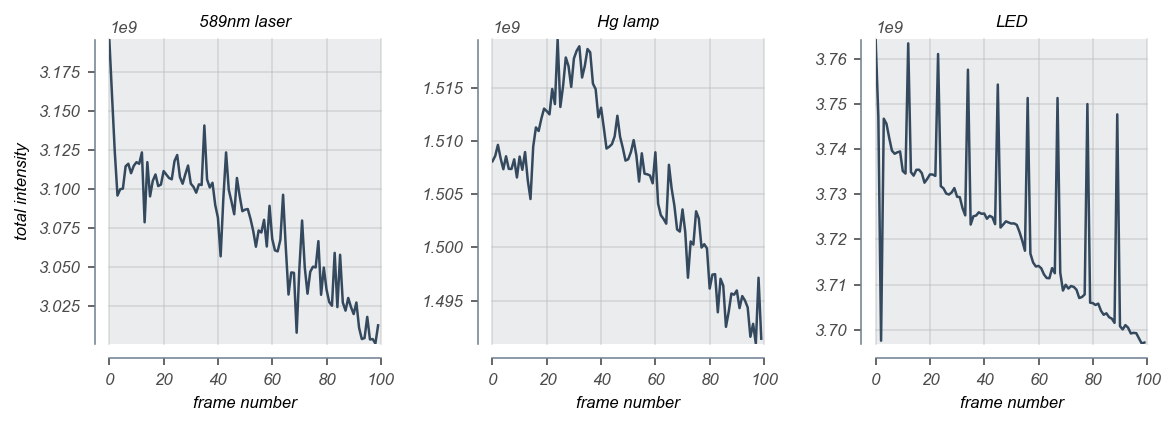

In [47]:

# Group by method. 
grouped = df.groupby('method')

# Set up a three row plot showing the total intensity as a function of time. 
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(8,3))

# Set up a dictionary for the plotting.
ax_dict = {'laser':0, 'hg':1, 'led':2}

ax[0].set_title('589nm laser')
ax[1].set_title('Hg lamp')
ax[2].set_title('LED')

ax[0].set_ylabel('total intensity')

# Iterate through the grouped dataframe and plot the raw data. 
for g, d in grouped:
    ax[ax_dict[g]].plot(d['time'], d['total_intensity'], '-')
    ax[ax_dict[g]].set_ylim([d['total_intensity'].min(), d['total_intensity'].max()])
    
for a in ax:
    a.set_xlabel('frame number')
    a.set_xlim([0, 100])

sns.despine(offset=7)
plt.tight_layout()

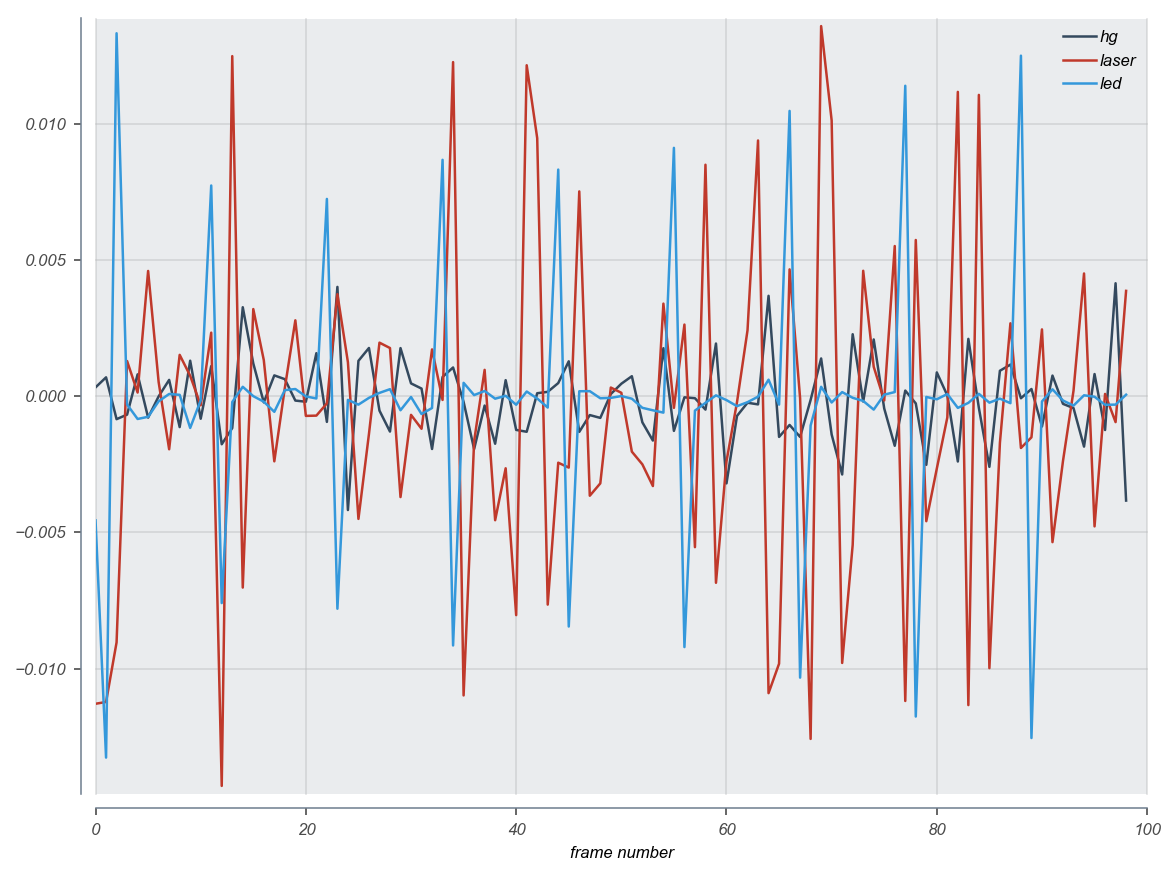

In [50]:
# Compute the differences. 
fig, ax = plt.subplots()
ax.set_xlabel('Δ frame number')
ax.set_ylabel('fractional differenc')
ax.set_xlim([0, 100])
# Set up a dictionary for the plotting. 
for g, d in grouped:
    _ = ax.plot(d['time'][:-1], np.diff(d['total_intensity']) / d.total_intensity.values[:-1], '-', label=g)
    

_ = ax.legend()
sns.despine(offset=7)
plt.tight_layout()

As I had gathered from my misery, it appears that the mercury lamp is more stable than the laser or even the LED. We can take a look at the distributions of this difference below.

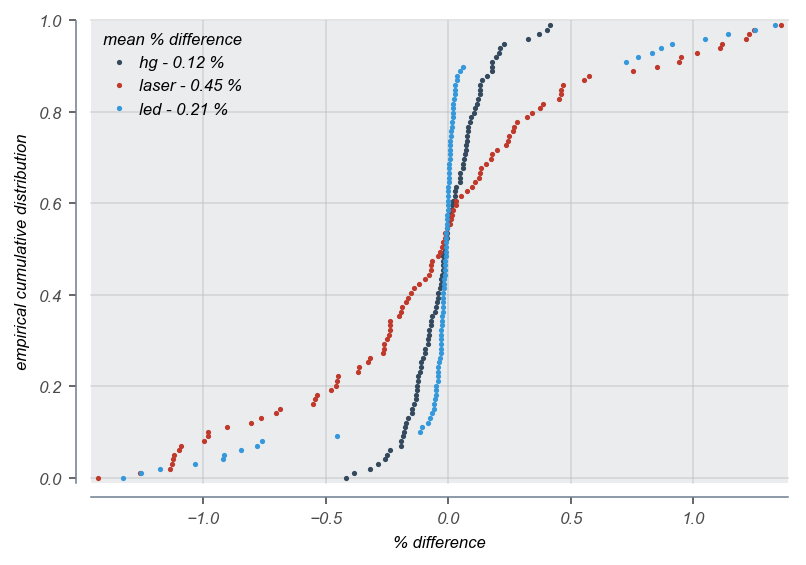

In [71]:
# Compute the ECDF distributions of these percent differences.
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('% difference')
ax.set_ylabel('empirical cumulative distribution')
mean_sq_diff = {}
for g, d in grouped:
    diff = np.diff(d['total_intensity']) / d['total_intensity'].values[:-1]
    mean_sq_diff[g] = np.mean(np.abs(diff))
    x, y = mwc.stats.ecdf(diff)
    _ = ax.plot(x * 100, y, '.', ms=3, label='{0} - {1:0.2f} %'.format(g, mean_sq_diff[g] * 100))
_l = ax.legend(title = 'mean % difference')
_l.get_title().set_fontsize(8)
sns.despine(offset=7)
 

It looks like the LED is more stable if those large jumps in intensity weren't occurring. HJ believes that this is a characteristic sign of shitty electronics and bets that frequency is 60Hz. Because I went back and forth between filter sets, I'm not 100% sure of the sampling frequency. As such, I can't compute the fourier transform to figure it out. However, this is something that I can take another shot at.  